In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

In [4]:
user_id = "1"
namespace_for_memory = (user_id, "memory")
key = str(uuid.uuid4())
value = {"food preference": "I really like pizza"}
in_memory_store.put(namespace_for_memory, key, value)

In [5]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [6]:
memories[0].dict()

{'namespace': ['1', 'memory'],
 'key': '007680b8-e680-4b41-9a03-e38036c5aae4',
 'value': {'food preference': 'I really like pizza'},
 'created_at': '2025-06-08T16:52:50.748548+00:00',
 'updated_at': '2025-06-08T16:52:50.748548+00:00',
 'score': None}

In [7]:
print(memories[0].key, memories[0].value)

007680b8-e680-4b41-9a03-e38036c5aae4 {'food preference': 'I really like pizza'}


In [8]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memory'],
 'key': '007680b8-e680-4b41-9a03-e38036c5aae4',
 'value': {'food preference': 'I really like pizza'},
 'created_at': '2025-06-08T16:52:50.748548+00:00',
 'updated_at': '2025-06-08T16:52:50.748548+00:00'}

In [9]:
_set_env("OPENAI_API_KEY")

In [ ]:
# Chat model
from langchain_openai import ChatOpenAI

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

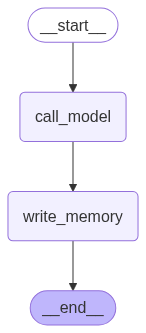

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
   # Get the user ID from the config
   user_id = config["configurable"]["user_id"]

   namespace = ("memory", user_id)
   key = "user_memory"
   existing_memory = store.get(namespace, key)

   if existing_memory:
      existing_memory_content = existing_memory.value.get("memory")
   else:
      existing_memory_content = "No existing memory found"
   
   # Format the memory in the system prompt
   system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
   # Respond using memory as well as the chat history
   response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

   return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
   # Get the user ID from the config
   user_id = config["configurable"]["user_id"]

   # Retrieve existing memory from the store
   namespace = ("memory", user_id)
   existing_memory = store.get(namespace, "user_memory")
        
   # Extract the memory
   if existing_memory:
      existing_memory_content = existing_memory.value.get('memory')
   else:
      existing_memory_content = "No existing memory found."
   
   # Format the memory in the system prompt
   system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
   new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

   # Overwrite the existing memory in the store 
   key = "user_memory"

   # Write value as a dictionary with a memory key
   store.put(namespace, key, {"memory": new_memory.content})

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_messages = [HumanMessage(content="Hi, my name is Swaraj")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Swaraj
================================== Ai Message ==================================

Hello Swaraj! It's nice to meet you. How can I assist you today?


In [14]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a fantastic way to explore the city, Swaraj! San Francisco has some great biking routes. Do you have a favorite trail or area you like to ride in?


In [15]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Swaraj
================================== Ai Message ==================================

Hello Swaraj! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a fantastic way to explore the city, Swaraj! San Francisco has some great biking routes. Do you have a favorite trail or area you like to ride in?


In [16]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '**User Information:**\n- Name: Swaraj\n- Likes biking around San Francisco'},
 'created_at': '2025-06-08T17:36:57.315865+00:00',
 'updated_at': '2025-06-08T17:36:57.315865+00:00'}

In [17]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Swaraj! Since you enjoy biking around San Francisco, there are some fantastic routes you might love:

1. **Golden Gate Park**: This is a classic choice with plenty of trails and beautiful scenery. You can explore the park's gardens, lakes, and even make your way to Ocean Beach.

2. **The Embarcadero**: A scenic ride along the waterfront, offering views of the Bay Bridge and access to Fisherman's Wharf.

3. **Marin Headlands**: If you're up for a bit of a challenge, biking across the Golden Gate Bridge and into the Marin Headlands offers stunning views of the city and the Pacific Ocean.

4. **Presidio**: This area has a mix of trails and roads with beautiful views of the Golden Gate Bridge and the bay.

5. **Angel Island**: You can take a ferry with your bike to Angel Island 

In [18]:
# User input 
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

Absolutely, Swaraj! Here are a few bakeries in San Francisco where you can enjoy a delicious croissant after your ride:

1. **Tartine Bakery**: Located in the Mission District, Tartine is famous for its pastries, and their croissants are a must-try.

2. **Arsicault Bakery**: Situated in the Richmond District, this bakery is renowned for its buttery, flaky croissants.

3. **b. Patisserie**: Found in Lower Pacific Heights, b. Patisserie offers a variety of pastries, including their popular croissants.

4. **Le Marais Bakery**: With locations in the Marina and Castro, Le Marais offers a delightful selection of French pastries.

5. **Neighbor Bakehouse**: Located in the Dogpatch, this bakery is known for its creative and delicious pastrie